In [ ]:
from google.colab import drive
drive.mount('/content/mydrive/')

Mounted at /content/mydrive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
import tensorflow as tf
from tensorflow import keras
import cv2
import pickle

AUDIO SPLITTING AND CONVERTING TO SPECTOGRAM

In [ ]:
#audio test
audio_data = '/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/genres_original/blues/blues.00000.wav'
data , sr = librosa.load(audio_data)
Audio(data, rate=sr)

In [ ]:
#audio split into 3 seconds wav file
!pip install pydub

In [ ]:
from pydub import AudioSegment
audio_dir = '/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/genres_original'

In [ ]:
for i,j in enumerate(os.listdir(audio_dir)):
  if i<5:
    genre_path = os.path.join(audio_dir,j)
    os.chdir(genre_path)
    print(os.getcwd())
    for song in os.listdir(genre_path):
      segment = 0
      song_name = song.split('.wav')[0]
      print(song_name)
      for i in range(0,30,3):
        t1 = i * 1000 #Works in milliseconds
        t2 = (i+3) * 1000
        newAudio = AudioSegment.from_wav(song)
        newAudio = newAudio[t1:t2]
        newAudio.export(f'/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/new_audio/{song_name}{segment}.wav', format="wav") #Exports to a wav file in the current path.
        segment += 1

/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/genres_original/blues
blues.00000
/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/genres_original/rock
rock.00000
/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/genres_original/metal
metal.00001
/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/genres_original/classical
classical.00007
/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/genres_original/reggae
reggae.00000


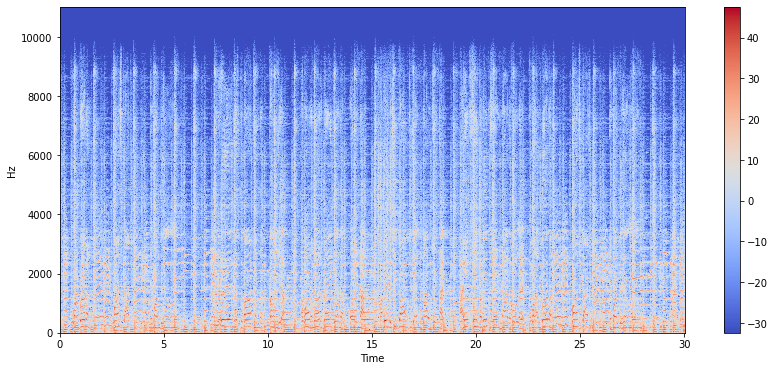

In [ ]:
# stft spectogram
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

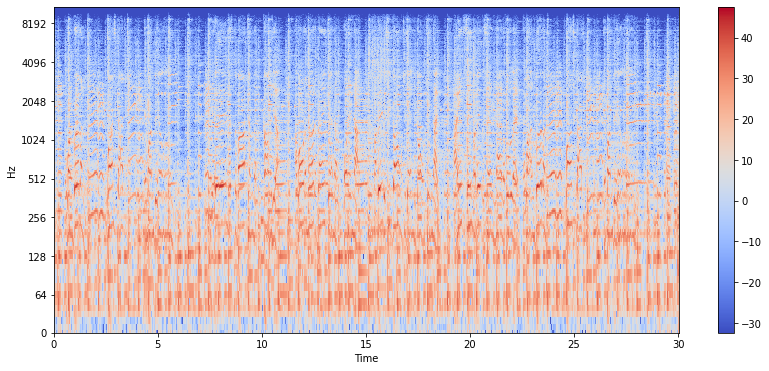

In [ ]:
# stft log plot
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

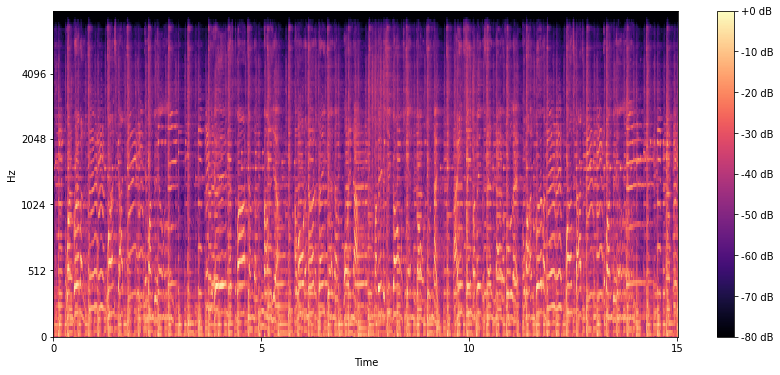

In [ ]:
# mel-spectogram
mel_spect = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
plt.figure(figsize=(14, 6))
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')

In [ ]:
# converting all extracted audio to spectogram
new_dir = '/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/new_audio'

# for large iamges, we need to do one genre at a time due to memory constraint

# for song in os.listdir(new_dir):
#   print(song.split('.')[0])
#   if song.split('.')[0] == "blues": # not able to convert all audio at once so going in one by one
#     song_name = song.split('.wav')[0]
#     data , sr = librosa.load(os.path.join(new_dir,song))
#     mel_spect = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=2048, hop_length=1024)
#     mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
#     plt.figure(figsize=(14, 6))             # this size may affect the size of the image we get saved
#     plt.axis('off')
#     librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
#     plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
#     plt.savefig(f"/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/new_image/{song_name}.png", bbox_inches=None, pad_inches=0)
#     plt.close('all')


# for small number of images

for song in os.listdir(new_dir):
  print(song.split('.')[0])
  song_name = song.split('.wav')[0]
  data , sr = librosa.load(os.path.join(new_dir,song))
  mel_spect = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=2048, hop_length=1024)
  mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
  plt.figure(figsize=(14, 6))             # this size may affect the size of the image we get saved
  plt.axis('off')
  librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
  plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  plt.savefig(f"/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/new_image/{song_name}.png", bbox_inches=None, pad_inches=0)
  plt.close('all')

SPECTOGRAM IMAGE PROCESSING 

432 X 1008 X 3


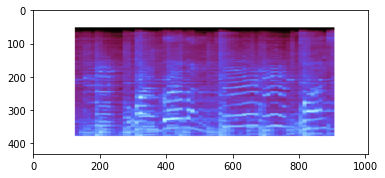

In [ ]:
# single image processing
img = cv2.imread('/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/new_image/blues.000000.png')
plt.imshow(img) 
height, width, channels = img.shape
print(height,"X",width,"X",channels)

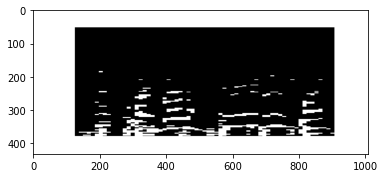

In [ ]:
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_grey, cmap='gray')
ret3,thresh = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

240891.5
125 51 783 328
(328, 783)


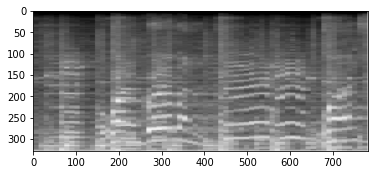

In [ ]:
# converting image into grayscale and cropping main image
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret3,thresh = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
(components, _) = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# getting contours
for c in components:
  if cv2.contourArea(c) > 200000 and cv2.contourArea(c) < 400000: #got the value from checking contour area of image by hit and trial 
    print(cv2.contourArea(c))
    (x, y, w, h) = cv2.boundingRect(c)
    print(x,y,w,h)
new_img = img_grey[y:y+h,x:x+w]
# plt.axis('off')
plt.imshow(new_img, cmap='gray')
print(new_img.shape)

In [ ]:
# for all newly extracted spectogram images
image_data = []
# specifying image height and width so that all images are same size to be given to ML model
img_h =  320
img_w = 780

In [ ]:
#image directory
img_dir = '/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/new_image'

for image in os.listdir(img_dir):
  # read image as grayscale to save memory and save model complexity by giving only one color channel
  img = cv2.imread(os.path.join(img_dir,image), cv2.IMREAD_GRAYSCALE)
  # applying threshold
  ret3,thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # taking out contours to get actual image without white border
  components, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  for c in components:
    if cv2.contourArea(c) > 200000 and cv2.contourArea(c) < 400000: #got the value from checking contour area of image by hit and trial 
      print(cv2.contourArea(c))
      (x, y, w, h) = cv2.boundingRect(c)
      print("Original image bounding:",x,y,w,h)
  # cropping required image
  cropped_img = img[y:y+h,x:x+w]
  resize_img = cv2.resize(cropped_img, (img_w,img_h))
  image_data.append((image,image.split('.')[0],resize_img))

Streaming output truncated to the last 5000 lines.
245871.0
Original image bounding: 125 51 783 328
246571.0
Original image bounding: 125 51 783 321
246364.5
Original image bounding: 125 51 783 324
246388.5
Original image bounding: 125 51 783 328
247397.5
Original image bounding: 125 51 783 324
245488.5
Original image bounding: 125 51 783 324
245738.0
Original image bounding: 125 51 783 324
245399.5
Original image bounding: 125 51 783 321
246758.5
Original image bounding: 125 51 783 328
255529.0
Original image bounding: 125 51 783 328
253390.0
Original image bounding: 125 51 783 328
255588.0
Original image bounding: 125 51 783 328
254988.0
Original image bounding: 125 51 783 328
250516.5
Original image bounding: 125 51 783 328
249116.5
Original image bounding: 125 51 783 328
253577.5
Original image bounding: 125 51 783 328
252863.5
Original image bounding: 125 51 783 328
251617.0
Original image bounding: 125 51 783 328
245575.0
Original image bounding: 125 51 783 324
244721.0
Original 

In [ ]:
image_data[-1]

('reggae.000001.png', 'reggae', array([[255, 252, 252, ..., 252, 252, 255],
        [254,   0,   0, ...,   0,   0, 254],
        [254,   0,   0, ...,   0,   0, 254],
        ...,
        [255,  98,  98, ..., 130, 130, 255],
        [255, 104, 104, ..., 112, 112, 255],
        [255, 253, 253, ..., 253, 253, 255]], dtype=uint8))

(320, 780)


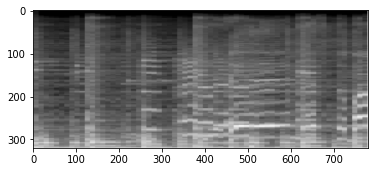

In [ ]:
plt.imshow(image_data[0][2], cmap='gray')
print(image_data[0][2].shape)

DATA PREPERATION AND PREPROCESSING

In [ ]:
df = pd.DataFrame(image_data, columns=['image_name','label','img_array'])

In [ ]:
df.head(10)

,image_name,label,img_array
0,blues.000002.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
1,blues.000003.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
2,blues.000004.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
3,blues.000005.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
4,blues.000006.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
5,blues.000007.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
6,blues.000008.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
7,blues.000009.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
8,blues.000050.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
9,blues.000051.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."


In [ ]:
with open('/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/audio_df', 'wb') as f:
  pickle.dump(df,f)
  # can skip if not required

In [ ]:
with open('/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/audio_df', 'rb') as f:
  data = pickle.load(f)

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

,image_name,label,img_array
0,rock.000449.png,rock,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,rock.000189.png,rock,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
2,blues.000235.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
3,reggae.000999.png,reggae,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
4,blues.000341.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
5,reggae.000074.png,reggae,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
6,reggae.000029.png,reggae,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
7,metal.000340.png,metal,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
8,metal.000379.png,metal,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."
9,reggae.000705.png,reggae,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,..."


In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [ ]:
label_encoder = LabelEncoder()
data['label_class'] = label_encoder.fit_transform(data['label']) 
# label will be converted to their number equivalent .... can create a new column if we want 

In [ ]:
output_classes = label_encoder.classes_
total_output_classes = len(label_encoder.classes_)
print("length of output classes: ",total_output_classes,'\n','all classes: ',output_classes)

length of output classes:  5 
 all classes:  ['blues' 'classical' 'metal' 'reggae' 'rock']


In [ ]:
# save the output classes that will be used at the time of prediction

with open('/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/output_classes', 'wb') as f:
  pickle.dump(output_classes,f)

In [ ]:
with open('/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/output_classes', 'rb') as f:
  output_classes = pickle.load(f)

In [ ]:
onehot = OneHotEncoder()
labels = onehot.fit_transform(data.label_class.values.reshape(-1,1)).toarray()
# reshaping as we single feature and converting to array to input it to model

In [ ]:
labels[:5]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

In [ ]:
data.head(10)

,image_name,label,img_array,label_class
0,rock.000449.png,rock,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",4
1,rock.000189.png,rock,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,...",4
2,blues.000235.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,...",0
3,reggae.000999.png,reggae,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,...",3
4,blues.000341.png,blues,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,...",0
5,reggae.000074.png,reggae,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,...",3
6,reggae.000029.png,reggae,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,...",3
7,metal.000340.png,metal,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,...",2
8,metal.000379.png,metal,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,...",2
9,reggae.000705.png,reggae,"[[255, 252, 252, 252, 252, 252, 252, 252, 252,...",3


In [ ]:
# prepare image input data for model
img_array = []
for img in data['img_array']:
  img = img.astype('float32') # convert image data into float to help in normalizing
  img = img/255.0             # normalizing image data between 0 and 1
  img = img.reshape(img_w,img_h,1)  # reshaping for model input 
  img_array.append(img)
img_array = np.array(img_array)
print(img_array.shape)

(5000, 780, 320, 1)


In [ ]:
img_array[1]

array([[[1.        ],
        [0.9882353 ],
        [0.9882353 ],
        ...,
        [0.9882353 ],
        [0.9882353 ],
        [0.9882353 ]],

       [[0.9882353 ],
        [0.9882353 ],
        [0.9882353 ],
        ...,
        [0.9882353 ],
        [0.9882353 ],
        [0.9882353 ]],

       [[0.9882353 ],
        [0.9882353 ],
        [0.9882353 ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.5568628 ],
        [0.5568628 ],
        [0.5568628 ],
        ...,
        [0.99607843],
        [0.99607843],
        [0.99607843]],

       [[0.99607843],
        [0.99607843],
        [0.99607843],
        ...,
        [0.99607843],
        [0.99607843],
        [0.99607843]],

       [[0.99607843],
        [0.99607843],
        [0.99607843],
        ...,
        [0.99215686],
        [0.99215686],
        [1.        ]]], dtype=float32)

{'boxes': [<matplotlib.lines.Line2D at 0x7f59fa18ba10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f59fa191ad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5a5213c650>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f59fa1965d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f59fa191050>,
  <matplotlib.lines.Line2D at 0x7f59fa191590>]}

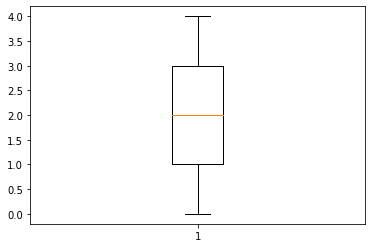

In [ ]:
#box plot of image labels 
plt.boxplot(data['label_class'])
# since the data is made using supervision, there will be no outliers and every image will be present between the 4 genres

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f59fa30aa90>],
 'cbars': <matplotlib.collections.LineCollection at 0x7f59fa30a890>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f59fa345450>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f59fa30afd0>}

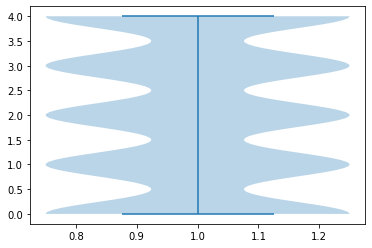

In [ ]:
# violin plot of image labels
plt.violinplot(dataset=data['label_class'])

Text(0, 0.5, 'label_class')

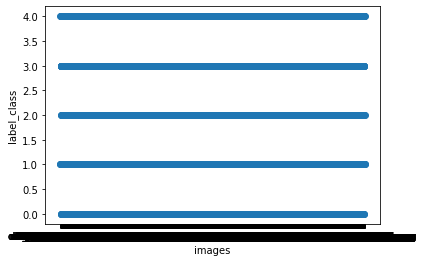

In [ ]:
#scatter plot of image_name x label_class
plt.scatter(data['image_name'], data['label_class'])
plt.xlabel('images')
plt.ylabel('label_class')

In [ ]:
# alternate way
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size=0.25, random_state=4)

MODEL PREPERATION

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.models import Model

In [ ]:
#keras functional API

i = Input(shape=(img_w,img_h,1))
x = Conv2D(32, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = GlobalMaxPooling2D()(x)

x = Flatten()(x)

x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(total_output_classes, activation='softmax')(x)
# x = Dense(5, activation='softmax')(x)

In [ ]:
model = Model(i,x)

In [ ]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
r = model.fit(img_array,labels,batch_size=24, validation_split=0.25, epochs=100)
# r = model.fit(X_train,y_train,labels,batch_size=8, validation_data=(X_test, y_test), epochs=10)

Epoch 1/5
7/7 [==============================] - 66s 9s/step - loss: 3.0946 - accuracy: 0.1351 - val_loss: 1.6093 - val_accuracy: 0.1538
Epoch 2/5
7/7 [==============================] - 56s 8s/step - loss: 3.5005 - accuracy: 0.1081 - val_loss: 1.6101 - val_accuracy: 0.1538
Epoch 3/5
7/7 [==============================] - 56s 8s/step - loss: 3.3781 - accuracy: 0.2432 - val_loss: 1.6212 - val_accuracy: 0.1538
Epoch 4/5
7/7 [==============================] - 56s 8s/step - loss: 3.5978 - accuracy: 0.2432 - val_loss: 1.6196 - val_accuracy: 0.1538
Epoch 5/5
7/7 [==============================] - 56s 8s/step - loss: 2.3309 - accuracy: 0.2973 - val_loss: 1.6167 - val_accuracy: 0.2308


In [ ]:
model.save('/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/audio_model_test.h5')

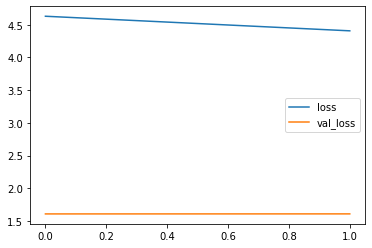

In [ ]:
# plotting the loss and validation loss of the model
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
# plt.savefig("/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/model_test_loss.png")

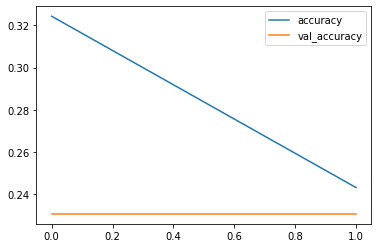

In [ ]:
# plotting the accuracy and validation accuracy of the model
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
# plt.savefig("/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/model_test_accuracy.png")

In [ ]:
model = keras.models.load_model('/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/audio_model_4.h5')

In [ ]:
#sample test data plots and reports
test_data = img_array[:1000]
test_labels = labels[:1000]
pred_labels = model.predict(test_data)

#or if you use test_train split, you can use X_test (in place of test_data) and y_test (in place of test_labels)

In [ ]:
# model evaluation
metric = model.evaluate(test_data,test_labels)
print(dict(zip(model.metrics_names, metric)))

32/32 [==============================] - 286s 9s/step - loss: 0.3217 - accuracy: 0.8710
{'loss': 0.32174527645111084, 'accuracy': 0.8709999918937683}


In [ ]:
print('Training Accuracy: ', r.history['accuracy'][-1])
print('validation Accuracy: ', r.history['val_accuracy'][-1])
print('Training loss: ', r.history['loss'][-1])
print('validation loss: ', r.history['val_loss'][-1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
#confusion matrix
matrix = confusion_matrix(test_labels.argmax(axis=1), pred_labels.argmax(axis=1))

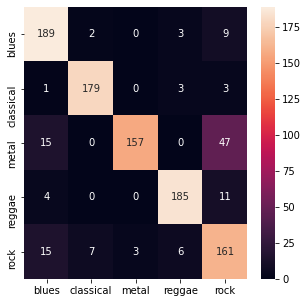

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True, fmt='', xticklabels=output_classes, yticklabels=output_classes)

In [ ]:
# classification report for recall, precision and f1 score
print(classification_report(test_labels.argmax(axis=1), pred_labels.argmax(axis=1), labels=[0,1,2,3,4], target_names=output_classes, zero_division=1))

              precision    recall  f1-score   support

       blues       0.88      0.97      0.92       214
   classical       0.95      0.94      0.94       199
       metal       0.99      0.69      0.81       190
      reggae       0.94      0.88      0.91       203
        rock       0.70      0.89      0.78       194

    accuracy                           0.88      1000
   macro avg       0.89      0.87      0.87      1000
weighted avg       0.89      0.88      0.88      1000



PREDICTION TEST

In [ ]:
# to test for trained song of 3 sec length 
audio_pred = '/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/new_audio/blues.000008.wav'
data , sr = librosa.load(audio_pred)
import IPython
IPython.display.Audio(data, rate=sr)

In [ ]:
# to test for untrained song and also if we want to take any 30 secong audio
song = '/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/genres_original/jazz/jazz.00000.wav'
segment = 0
song_name = song.split('.wav')[0]
print(song_name)
for i in range(0,30,3):
  t1 = i * 1000 #Works in milliseconds
  t2 = (i+3) * 1000
  newAudio = AudioSegment.from_wav(song)
  newAudio = newAudio[t1:t2]
  newAudio.export(f'new{segment}.wav', format="wav") #Exports to a wav file in the current path.
  segment += 1
data , sr = librosa.load('new0.wav')
import IPython
IPython.display.Audio(data, rate=sr)

/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/genres_original/jazz/jazz.00000


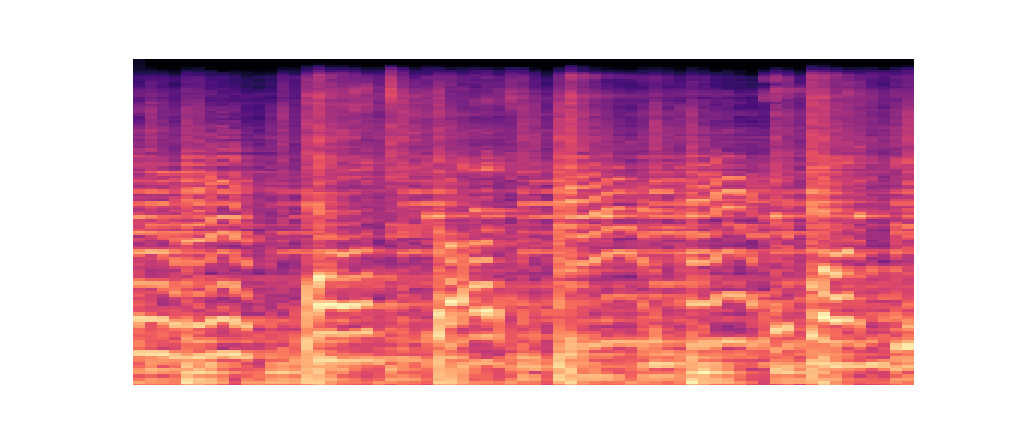

In [ ]:
mel_spect = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
plt.figure(figsize=(14, 6))             # this size may affect the size of the image we get saved
plt.axis('off')
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
# plt.colorbar(format='%+2.0f dB')
plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
plt.savefig("new_song.png", bbox_inches=None, pad_inches=0)
# plt.close('all')
# plt.title('Mel Spectrogram');


In [ ]:
img = cv2.imread('new_song.png', cv2.IMREAD_GRAYSCALE)
img_h =  320
img_w = 780

In [ ]:
ret3,thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# taking out contours to get actual image without white border
components, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for c in components:
  if cv2.contourArea(c) > 200000 and cv2.contourArea(c) < 400000: #got the value from checking contour area of image by hit and trial 
    print(cv2.contourArea(c))
    (x, y, w, h) = cv2.boundingRect(c)
    print("Original image bounding:",x,y,w,h)
# cropping required image
cropped_img = img[y:y+h,x:x+w]
resize_img = cv2.resize(cropped_img, (img_w,img_h))

241864.5
Original image bounding: 125 51 783 328


[[255 252 252 ... 252 252 255]
 [254  13  13 ...   0   0 254]
 [254  13  13 ...   0   0 254]
 ...
 [255 185 185 ... 152 152 255]
 [255 157 157 ... 156 156 255]
 [255 254 254 ... 254 254 255]]


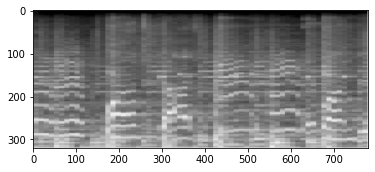

In [ ]:
plt.imshow(resize_img, cmap='gray')
print(resize_img)

In [ ]:
input_img = resize_img.astype('float32')
input_img = input_img/255.0
print(input_img)
input_img = input_img.reshape(-1,img_w,img_h,1)
print(input_img.shape)

[[1.         0.9882353  0.9882353  ... 0.9882353  0.9882353  1.        ]
 [0.99607843 0.05098039 0.05098039 ... 0.         0.         0.99607843]
 [0.99607843 0.05098039 0.05098039 ... 0.         0.         0.99607843]
 ...
 [1.         0.7254902  0.7254902  ... 0.59607846 0.59607846 1.        ]
 [1.         0.6156863  0.6156863  ... 0.6117647  0.6117647  1.        ]
 [1.         0.99607843 0.99607843 ... 0.99607843 0.99607843 1.        ]]
(1, 780, 320, 1)


In [ ]:
model = keras.models.load_model('/content/mydrive/MyDrive/Colab Notebooks/data/audio classification/Data/audio_model_4.h5')

In [ ]:
pred = model.predict(input_img)
print(pred)
y = np.argmax(pred)
print(y)

# to test for unclassified song
print(pred[0][y])
if pred[0][y]>0.5:
  word = output_classes[y]
  print(word)
else:
  print('can not classify')  

# previous code
word = output_classes[y]
  print(word)

[[0.8733192  0.0031772  0.00302154 0.01857221 0.10190993]]
0
0.8733192
blues
